## Detecting mitotic figures using Amazon Rekognition Custom Labels

Mitotic figures are cells that are dividing via a process called _mitosis_ to create two new cells. Identifying and counting these mitotic figures is part of histopathology tissue analysis, considered the gold standard in cancer diagnosis. A pathologist will usually take hematoxylin-eosin stained tissue samples and identify these and other features when evaluating tumors.

This process depends entirely on pathologists and is costly and time consuming. As technology evolves, whole-slide imaging (WSI) techniques have enabled laboratories to start scanning and digitizing samples. And with the recent advances in machine learning (ML), it has now become feasible to build systems that can help pathologists by automatic the detection of abnormal and/or relevant features in pathology slides.

In this workshop, we will explore how Amazon Rekognition Custom Labels can be used to implement such automated detection systems by processing WSI data, and using it to train a custom model that detects mitotic figures.

## Install dependencies

To prepare our SageMaker Studio application instance, we will update system packages first.

In [ ]:
!apt update > /dev/null && apt dist-upgrade -y > /dev/null

For the WSI data, we need the [OpenSlide](https://openslide.org) library and tooling, which we can install using `apt`.

In [ ]:
!apt install -y build-essential openslide-tools python-openslide libgl1-mesa-glx > /dev/null

We also use [SlideRunner](https://github.com/DeepPathology/SlideRunner) and [fastai](https://fast.ai) to load and process the slides, which we need to install by using `pip`.

In [ ]:
!pip install SlideRunner SlideRunner_dataAccess fastai==1.0.61 > /dev/null

## Downloading the dataset

We will use the MITOS_WSI_CMC dataset, which is available on [GitHub](https://github.com/DeepPathology/MITOS_WSI_CMC). Images are downloaded from Figshare.

This step takes approximately 10-12 minutes. If you are not running this as a self-paced lab, your instructor will make a pause here, and introduce you to other necessary concepts while waiting.

In [ ]:
from dataset import download_dataset
download_dataset()

## Loading the data

In the previous step, you downloaded the WSI files from which you will generate the training and test images for Amazon Rekognition. However, you still need the labels for each of the mitotic figures in those images. These are stored in a sqlite database that is the dataset's repository. We will download the database now.

In [ ]:
%reload_ext autoreload
%autoreload 2

import os
from typing import List
import urllib

import numpy as np
from SlideRunner.dataAccess.database import Database
from pathlib import Path


DATABASE_URL = 'https://github.com/DeepPathology/MITOS_WSI_CMC/raw/master/databases/MITOS_WSI_CMC_MEL.sqlite'
DATABASE_FILENAME = 'MITOS_WSI_CMC_MEL.sqlite'


Path("./databases").mkdir(parents=True, exist_ok=True)

local_filename, headers = urllib.request.urlretrieve(
    DATABASE_URL,
    filename=os.path.join('databases', DATABASE_FILENAME),
)

## Setup

There are a few things we still need to define before moving on:

### Storage

We need an Amazon S3 bucket to place the image files, so that Amazon Rekognition can read those during training and testing. We will use the default Amazon SageMaker bucket that is automatically created for you.

### Database

To have access to the annotations, we need to open the database using `SlideRunner`.

### Test slides

We need to define a set of test slides to set apart. These will be used to assess your model's ability to generalize, and thus cannot be used to generate training data. That is the reason we are defining them beforehand.

There are three different arrays with different test slides defined for each. By default, the first set of test slides is used, by you can go ahead and try different combinations.

In [ ]:
import sagemaker
sm_session = sagemaker.Session()

size=512
bucket_name = sm_session.default_bucket()

database = Database()
database.open(os.path.join('databases', DATABASE_FILENAME))

slidelist_test_1 = ['14','18','3','22','10','15','21']
slidelist_test_2 = ['1','20','17','5','2','11','16']
slidelist_test_3 = ['13','7','19','8','6','9', '12']
slidelist_test = slidelist_test_1

## Retrieve the slides

Now we can call the `get_slides` function, which will produce a list of training and test slides we can use to generate the training and test images. The code for this function is in the `sampling.py` file.

We need to pass:
* A reference to the database object, so that annotations can be read and linked to the slides.
* A list of slides to use to generate the test dataset (and to exclude from the training dataset).
* The ID of the negative class - Not used in this workshop.
* The size (both width and height), in pixels, of the image that is generated when `get_patch` is invoked on a `SlideContainer`. This effectively sets the size of the image that is created for Amazon Rekognition.

In [ ]:
from sampling import get_slides

image_size = 512

lbl_bbox, training_slides, test_slides, files = get_slides(database, slidelist_test, negative_class=1, size=image_size)

## Shuffle the slides

We want to randomly sample from the training and test slides. Using the lists of training and test slides, we will randomly select `n_training_images` times a file for training, and `n_test_images` times a file for test. Notice that we have chosen to have a test set that contains 20% the number of images the training set has.

In [ ]:
n_training_images = 500
n_test_images = int(0.2 * n_training_images)

training_files = list([
    (y, files[y]) for y in np.random.choice(
        [x for x in training_slides], n_training_images)
])
test_files = list([
    (y, files[y]) for y in np.random.choice(
        [x for x in test_slides], n_test_images)
])

## Create the images for training the Rekognition Custom Labels model

In [ ]:
Path("rek_slides/training").mkdir(parents=True, exist_ok=True)
Path("rek_slides/test").mkdir(parents=True, exist_ok=True)

We need to build JSON lines manifest.

In [ ]:
def get_annotation_json_line(filename, channel, annotations, labels):
    
    objects = list([{'confidence' : 1} for i in range(0, len(annotations))])
    
    return json.dumps({
        'source-ref': f's3://{bucket_name}/data/{channel}/{filename}',
        'bounding-box': {
            'image_size': [{
                'width': size,
                'height': size,
                'depth': 3
            }],
            'annotations': annotations,
        },
        'bounding-box-metadata': {
            'objects': objects,
            'class-map': dict({ x: str(x) for x in labels }),
            'type': 'groundtruth/object-detection',
            'human-annotated': 'yes',
            'creation-date': datetime.datetime.now().isoformat(),
            'job-name': 'rek-pathology',
        }
    })

def generate_annotations(x_start: int, y_start: int, bboxes, labels, filename: str, channel: str):
    annotations = []
    
    for bbox in bboxes:
        if check_bbox(x_start, y_start, bbox):
            # Get coordinates relative to this slide.
            x0 = bbox.left - x_start
            y0 = bbox.top - y_start
            
            annotation = {
                'class_id': 1,
                'top': y0,
                'left': x0,
                'width': bbox.right - bbox.left,
                'height': bbox.bottom - bbox.top
            }
            
            annotations.append(annotation)
    
    return get_annotation_json_line(filename, channel, annotations, labels)

Next, we get random pieces of our images to use for training.

In [ ]:
import datetime
import json
import random

from fastai import *
from fastai.vision import *
from tqdm.notebook import tqdm


# Margin size, in pixels, for training images. This is the space we leave on
# each side for the bounding box(es) to be well into the image.
margin_size = 64

training_annotations = []
test_annotations = []

def check_bbox(x_start: int, y_start: int, bbox) -> bool:
    return (bbox._left > x_start and
            bbox._right < x_start + image_size and
            bbox._top > y_start and
            bbox._bottom < y_start + image_size)


def generate_images(file_list) -> None:
    for f_idx in tqdm(range(0, len(file_list)), desc='Writing training images...'):
        slide_idx, f = file_list[f_idx]
        bboxes = lbl_bbox[slide_idx][0]
        labels = lbl_bbox[slide_idx][1]

        # Calculate the minimum and maximum horizontal and vertical positions
        # that bounding boxes should have within the image.
        x_min = min(map(lambda x: x.left, bboxes)) - margin_size
        y_min = min(map(lambda x: x.top, bboxes)) - margin_size
        x_max = max(map(lambda x: x.right, bboxes)) + margin_size
        y_max = max(map(lambda x: x.bottom, bboxes)) + margin_size

        result = False
        while not result:
            x_start = random.randint(x_min, x_max - image_size)
            y_start = random.randint(y_min, y_max - image_size)

            for bbox in bboxes:
                if check_bbox(x_start, y_start, bbox):
                    result = True
                    break

        filename = f'slide_{f_idx}.png'
        channel = 'test' if slide_idx in test_slides else 'training'
        annotation = generate_annotations(x_start, y_start, bboxes, labels, filename, channel)

        if channel == 'training':
            training_annotations.append(annotation)
        else:
            test_annotations.append(annotation)

        img = Image(pil2tensor(f.get_patch(x_start, y_start) / 255., np.float32))
        img.save(f'rek_slides/{channel}/{filename}')

generate_images(training_files)
generate_images(test_files)


## Write the manifest files to disk

The previous cell generated a series of annotations in the Amazon SageMaker Ground Truth format, which is the same Amazon Rekognition expects. The specifics for object detection are detailed [in the documentation](https://docs.aws.amazon.com/rekognition/latest/customlabels-dg/cd-manifest-files-object-detection.html).

Annotations were stored in the `training_annotations` and `test_annotations` lists. Now, we need to write a `manifest.json` file with the contents of each list into the _training_ and _test_ directories.

In [ ]:
with open('rek_slides/training/manifest.json', 'w') as mf:
    mf.write("\n".join(training_annotations))

with open('rek_slides/test/manifest.json', 'w') as mf:
    mf.write("\n".join(test_annotations))

## Transfer the files to S3

Having written the images and the manifest file, we can now upload everything to our S3 bucket. We will use the `upload_data` method exposed by the SageMaker `Session` object, which recursively uploads the contents of a directory to S3.

In [ ]:
import sagemaker


sm_session = sagemaker.Session()
data_location = sm_session.upload_data(
    './rek_slides',
    bucket=bucket_name,
)

## Create an Amazon Rekognition Custom Labels project

With our data already in S3, we can take the first step towards training a custom model, and create a Custom Labels project. Using the `boto3` library, we create an Amazon Rekognition client and invoke the `create_project` method. This method only takes a project name as input. If succesful, it returns the ARN (Amazon Resource Name) of the newly created project, which we need to save for future use.

If you already created the project and just want to retrieve its ARN, you can use the `describe_projects` method exposed by the Amazon Rekognition client, and then retrieve the ARN from the list of projects returned. The commented line assumes that you only have one project and retrieves the ARN from the first description in the list. If you are doing this as a self-paced lab and have previously used Rekognition, be aware that using the zero index may not retrieve the ARN of your workshop project.

In [ ]:
import boto3

project_name = 'rek-mitotic-figures-workshop'

rek = boto3.client('rekognition')
response = rek.create_project(ProjectName=project_name)

# If you have already created the project, use the describe_projects call to
# retrieve the project ARN.
# response = rek.describe_projects()['ProjectDescriptions'][0]

project_arn = response['ProjectArn']
project_arn

## Create a project version

To create a project version, we need to specify:
* The name of the version.
* The name of the bucket, along with a prefix under which you want the training results to be stored.
* Test and a training datasets.

For the test and training datasets, you need to tell Amazon Rekognition where you training and test images are stored. The information is contained in the `manifest.json` files that we created in an earlier step, and all we need to do know is to indicate where they are stored.

In [ ]:
version_name = '1'

output_config = {
    'S3Bucket': bucket_name,
    'S3KeyPrefix': 'output',
}

training_dataset = {
    'Assets': [
        {
            'GroundTruthManifest': {
                'S3Object': {
                    'Bucket': bucket_name,
                    'Name': 'data/training/manifest.json'
                }
            },
        },
    ]
}

testing_dataset = {
    'Assets': [
        {
            'GroundTruthManifest': {
                'S3Object': {
                    'Bucket': bucket_name,
                    'Name': 'data/test/manifest.json'
                }
            },
        },
    ]
}

We also define a helper function to describe the different versions of a project.

In [ ]:
def describe_project_versions():
    describe_response = rek.describe_project_versions(
        ProjectArn=project_arn,
        VersionNames=[version_name],
    )

    for model in describe_response['ProjectVersionDescriptions']:
        print(f"Status: {model['Status']}")
        print(f"Message: {model['StatusMessage']}")
    
    return describe_response

All that is left to do is to invoke the `create_project_version` method with the parameters we just defined. Calling this method start the task of training a model asynchronously. To wait for the task to finish, we create a _waiter_, which will poll the service periodically and exit once the model has either been successfully trained, or an error has occurred.

In [ ]:
response = rek.create_project_version(
    VersionName=version_name,
    ProjectArn=project_arn,
    OutputConfig=output_config,
    TrainingData=training_dataset,
    TestingData=testing_dataset,
)

waiter = rek.get_waiter('project_version_training_completed')
waiter.wait(
    ProjectArn=project_arn,
    VersionNames=[version_name],
)

describe_response = describe_project_versions()

## Using the model

If you got this far, it means that your project is ready to run! Before you can start doing inference with your Amazon Rekognition Custom Labels model, you need to start the model.

### Start the model

To start the model, simply call the `start_project_version` method. You will need to provide two parameters:
* Your project version ARN.
* A number of inference units.

The number of inference units is related to the amount of resources deployed for your model. The higher the number of inference units you allocate, the higher the throughput you can achieve. However, since you are billed based on the number of inference units as well, the higher the cost.

The model can take a 5-15 minutes to deploy. If doing this as an instructor-led workshop, your instructor will use this time to answer questions or deliver additional content.

In [ ]:
%%time
model_arn = describe_response['ProjectVersionDescriptions'][0]['ProjectVersionArn']

response = rek.start_project_version(
    ProjectVersionArn=model_arn,
    MinInferenceUnits=1,
)
waiter = rek.get_waiter('project_version_running')
waiter.wait(
    ProjectArn=project_arn,
    VersionNames=[version_name],
)

describe_project_versions()

### Submit an image for inference

Our trained model is now ready for inference. Use any of the files in the `rek_slides/test` and send it over to your endpoint by using the `detect_custom_labels` method of the SDK to see how your model is now able to detect mitotic figures in microscopy images.

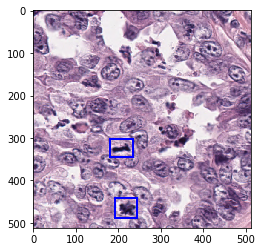

In [33]:
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw


# We'll use one of our test images to try out our model.
with open('./rek_slides/test/slide_0.png', 'rb') as image_file:
    image_bytes=image_file.read()


# Send the image data to the model.
response = rek.detect_custom_labels(
    ProjectVersionArn=model_arn,
    Image={
        'Bytes': image_bytes
    }
)


# 
img = Image.open(io.BytesIO(image_bytes))
draw = ImageDraw.Draw(img)

for custom_label in response['CustomLabels']:
    geometry = custom_label['Geometry']['BoundingBox']
    w = geometry['Width'] * img.width
    h = geometry['Height'] * img.height
    l = geometry['Left'] * img.width
    t = geometry['Top'] * img.height
    draw.rectangle([l, t, l + w, t + h], outline=(0, 0, 255, 255), width=5)

plt.imshow(np.asarray(img))